### Library

- [Kaggle Data](https://www.kaggle.com/datasets/mauriziocalabrese/soldef-ai-pcb-dataset-for-defect-detection)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import torch
import yaml
import warnings
from ultralytics import YOLO
from tqdm import tqdm
from pathlib import Path
warnings.filterwarnings('ignore')

### EDA

In [ ]:
def load_dataset(data_dir="dataset/raw", split="train"):
    data_dir = Path(data_dir)
    data_yaml_path = data_dir / 'data.yaml'
    class_names_map = {}

    if data_yaml_path.exists():
        with open(data_yaml_path, 'r') as f:
            data_yaml = yaml.safe_load(f)
            names = data_yaml.get('names', {})

            # names 구조 통일 (list / dict 대응)
            if isinstance(names, list):
                class_names_map = {i: name for i, name in enumerate(names)}
            elif isinstance(names, dict):
                class_names_map = {int(k): v for k, v in names.items()}
    else:
        print(f"Warning: {data_yaml_path} not found. Class names will not be loaded.")

    split_dir = data_dir / split
    images_dir = split_dir / "images"
    labels_dir = split_dir / "labels"
    image_files = list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png"))

    data_list = []

    for img_path in tqdm(image_files, desc=f"Loading {split}"):
        label_path = labels_dir / f"{img_path.stem}.txt"

        # 이미지 크기 읽기
        try:
            img = cv2.imread(str(img_path))
            height, width, _ = img.shape
        except Exception as e:
            print(f"Could not read image {img_path}: {e}")
            height, width = None, None

        # 기본값
        class_id = None
        class_name = None
        num_objects = 0 

        if label_path.exists():
            try:
                class_ids = []
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    num_objects = len(lines)  

                    for line in lines:
                        cid = int(line.split()[0])
                        class_ids.append(cid)

                # 중복 제거 + 대표 class 하나 선택
                class_ids = list(dict.fromkeys(class_ids))
                class_id = class_ids[0]
                class_name = class_names_map.get(class_id)

            except Exception as e:
                print(f"Could not read label file {label_path}: {e}")

        else:
            # 정상 이미지
            class_id = -1
            class_name = "normal"
            num_objects = 0  

        data_list.append({
            "image_path": str(img_path),
            "label_path": str(label_path) if label_path.exists() else None,
            "split": split,
            "image_name": img_path.name,
            "width": width,
            "height": height,
            "class_id": class_id,
            "class_name": class_name,
            "num_objects": num_objects,  
        })

    df = pd.DataFrame(data_list)
    print(f"Loaded {len(df)} {split} samples")
    return df

In [3]:
train_df = load_dataset("../dataset/raw", "train")
val_df = load_dataset("../dataset/raw", "val")
test_df = load_dataset("../dataset/raw", "test")

print(f"\nTrain Data: {len(train_df)}")
print(f"Val Data: {len(val_df)}")
print(f"Test Data: {len(test_df)}")

Loading train: 100%|██████████| 8534/8534 [00:10<00:00, 788.96it/s]


Loaded 8534 train samples


Loading val: 100%|██████████| 1066/1066 [00:01<00:00, 724.25it/s]


Loaded 1066 val samples


Loading test: 100%|██████████| 1068/1068 [00:01<00:00, 755.96it/s]

Loaded 1068 test samples

Train Data: 8534
Val Data: 1066
Test Data: 1068


### Train

In [4]:
train_df

,image_path,label_path,split,image_name,width,height,class_id,class_name,num_objects
0,../dataset/raw/train/images/light_12_short_07_...,None,train,light_12_short_07_1_600.jpg,600,600,-1,normal,0
1,../dataset/raw/train/images/rotation_270_light...,../dataset/raw/train/labels/rotation_270_light...,train,rotation_270_light_06_open_circuit_08_3_600.jpg,601,601,4,open_circuit,1
2,../dataset/raw/train/images/rotation_270_light...,../dataset/raw/train/labels/rotation_270_light...,train,rotation_270_light_04_spurious_copper_04_1_600...,601,601,5,spurious_copper,2
3,../dataset/raw/train/images/rotation_270_light...,../dataset/raw/train/labels/rotation_270_light...,train,rotation_270_light_11_spurious_copper_10_1_600...,601,601,5,spurious_copper,1
4,../dataset/raw/train/images/rotation_90_light_...,../dataset/raw/train/labels/rotation_90_light_...,train,rotation_90_light_06_spurious_copper_08_1_600.jpg,600,600,5,spurious_copper,1
...,...,...,...,...,...,...,...,...,...
8529,../dataset/raw/train/images/rotation_270_light...,../dataset/raw/train/labels/rotation_270_light...,train,rotation_270_light_01_spurious_copper_14_1_600...,601,601,5,spurious_copper,1
8530,../dataset/raw/train/images/rotation_90_light_...,../dataset/raw/train/labels/rotation_90_light_...,train,rotation_90_light_09_mouse_bite_10_2_600.jpg,600,600,0,mouse_bite,1
8531,../dataset/raw/train/images/light_12_spur_05_2...,None,train,light_12_spur_05_2_600.jpg,600,600,-1,normal,0
8532,../dataset/raw/train/images/l_light_05_short_0...,../dataset/raw/train/labels/l_light_05_short_0...,train,l_light_05_short_09_2_600.jpg,600,600,3,short,1


In [23]:
def count_plot(df, x_col, figsize=(8, 6), title=None, rotation=0, palette="Blues_r"):
    plt.figure(figsize=figsize)
    
    sns.countplot(
        data=df,
        x=x_col,
        order=df[x_col].value_counts().index, # 빈도순 정렬
        palette=palette
    )
    
    plt.title(title if title else f"Count of {x_col}")
    plt.xlabel(x_col)
    plt.ylabel("Count")
    
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

# hist_plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None, title=None):
    plt.figure(figsize=figsize)

    # 개별 데이터 프레임
    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    
    if df2 is not None: # 두 그룹 비교
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2 if label2 else 'Group 2')
        plt.legend()  # 두 그룹일 때만 범례 표시

    plt.title(title if title else f'{col} Distribution (Histogram + KDE)')
    plt.xlabel(col)
    plt.show()

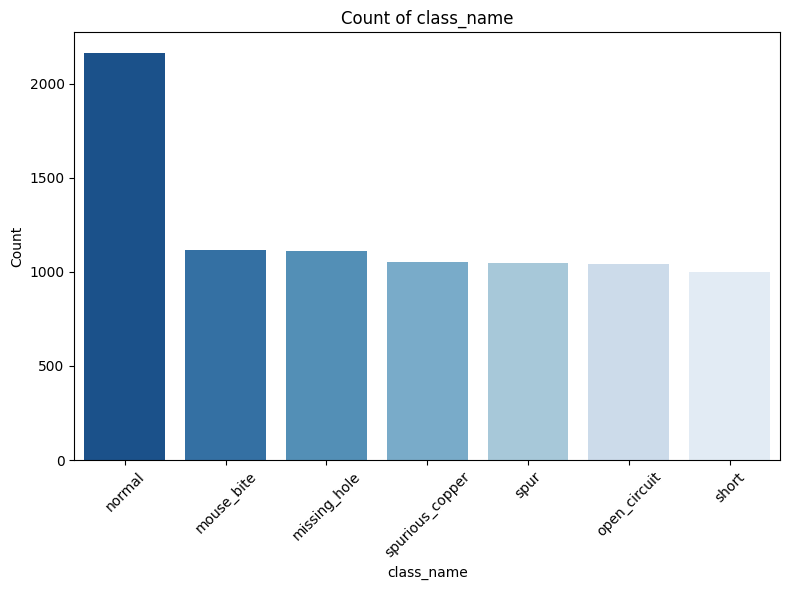

,class_name,count
0,normal,2164
1,mouse_bite,1118
2,missing_hole,1111
3,spurious_copper,1054
4,spur,1046
5,open_circuit,1042
6,short,999


In [6]:
count_plot(df=train_df, x_col='class_name', rotation=45)
train_df['class_name'].value_counts().reset_index()

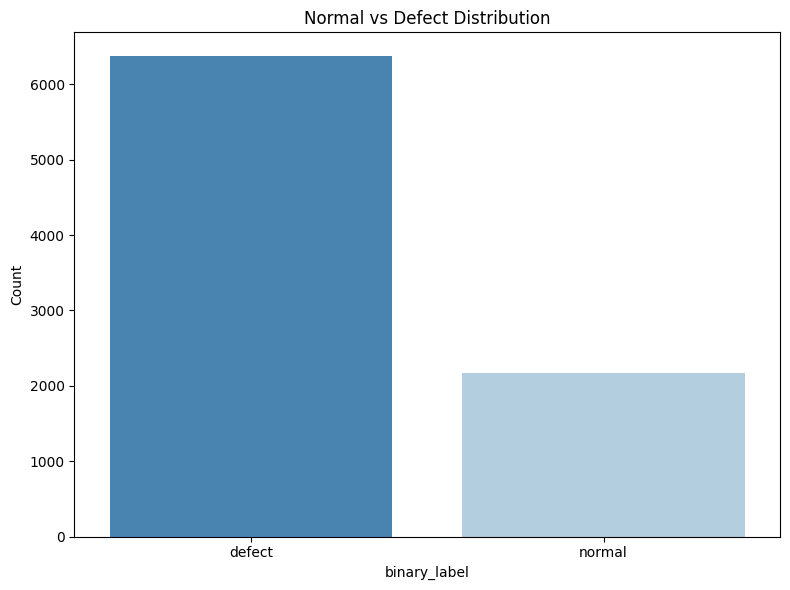

In [7]:
train_df['binary_label'] = train_df['class_name'].apply(
    lambda x: 'normal' if x == 'normal' else 'defect'
)

count_plot(
    train_df,
    x_col='binary_label',
    title='Normal vs Defect Distribution'
)

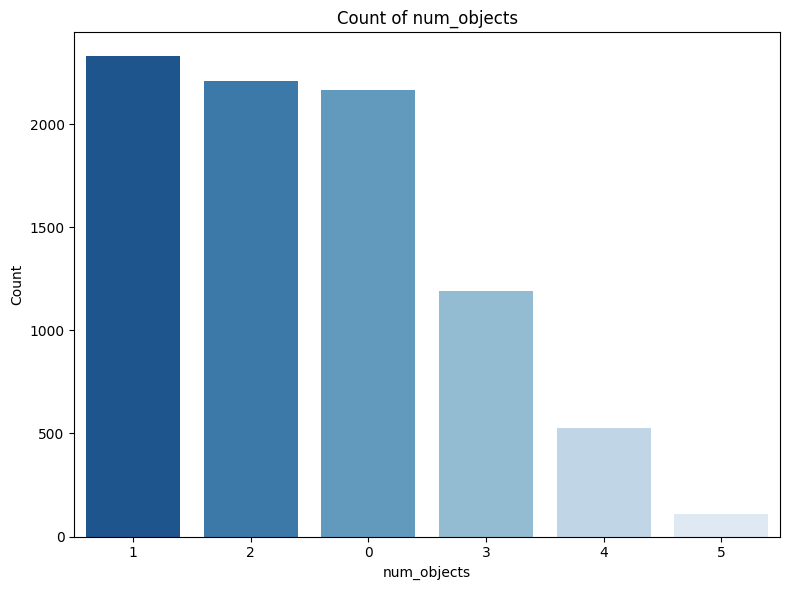

,num_objects,count,num_objects_ratio
0,1,2329,27.29
1,2,2210,25.90
2,0,2164,25.36
3,3,1193,13.98
4,4,527,6.18
5,5,111,1.30


In [19]:
count_plot(train_df, x_col='num_objects')
num_objects = train_df['num_objects'].value_counts().reset_index()
num_objects.columns = ['num_objects', 'count']

num_objects['num_objects_ratio'] = (
    num_objects['count'] / len(train_df) * 100
).round(2)
num_objects

### Val

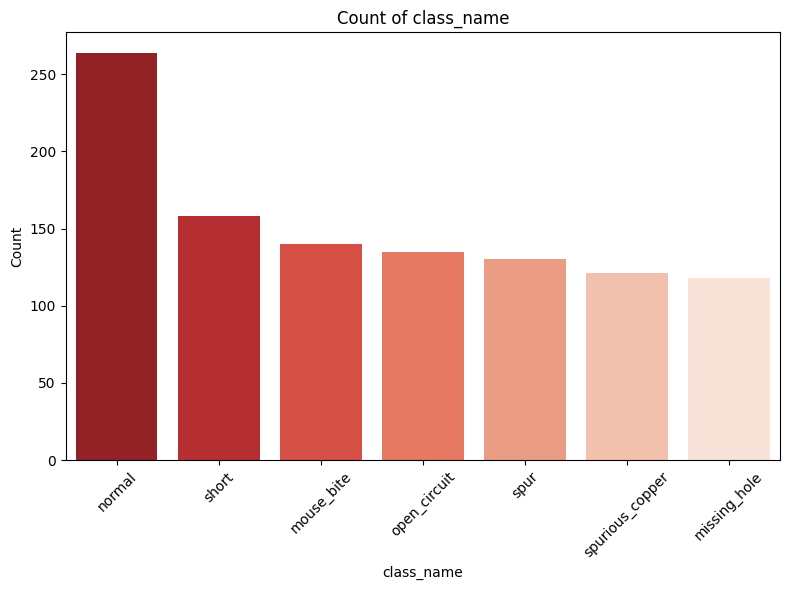

,class_name,count
0,normal,264
1,short,158
2,mouse_bite,140
3,open_circuit,135
4,spur,130
5,spurious_copper,121
6,missing_hole,118


In [24]:
count_plot(df=val_df, x_col='class_name', rotation=45, palette='Reds_r')
val_df['class_name'].value_counts().reset_index()

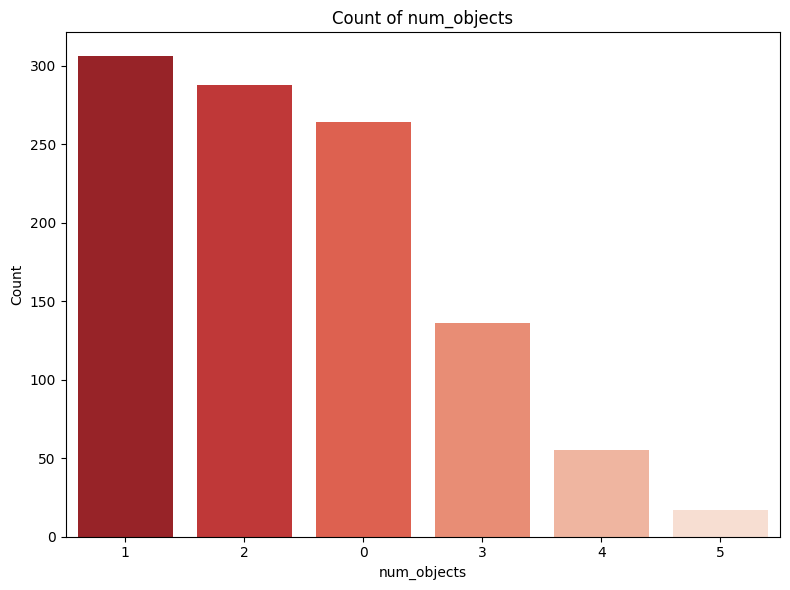

,num_objects,count,num_objects_ratio
0,1,306,28.71
1,2,288,27.02
2,0,264,24.77
3,3,136,12.76
4,4,55,5.16
5,5,17,1.59


In [25]:
count_plot(val_df, x_col='num_objects', palette='Reds_r')
num_objects = val_df['num_objects'].value_counts().reset_index()
num_objects.columns = ['num_objects', 'count']

num_objects['num_objects_ratio'] = (
    num_objects['count'] / len(val_df) * 100
).round(2)
num_objects

### Test

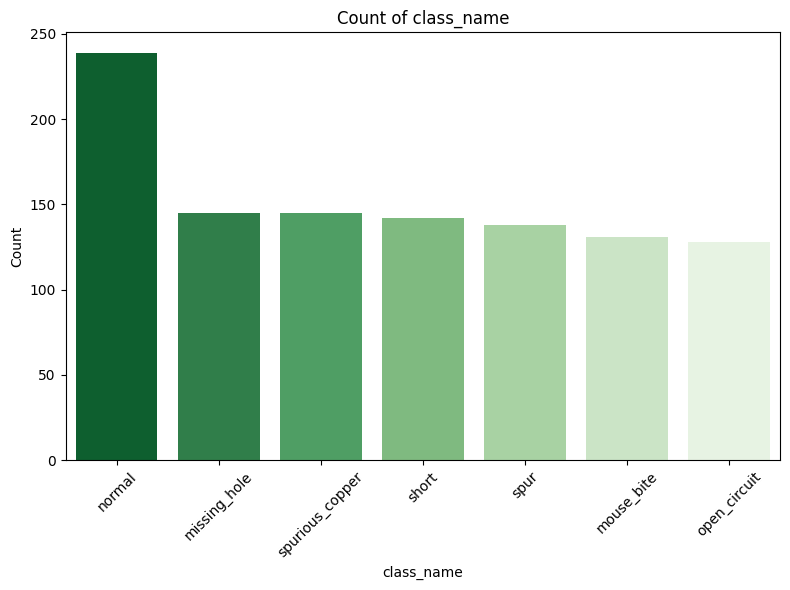

,class_name,count
0,normal,239
1,missing_hole,145
2,spurious_copper,145
3,short,142
4,spur,138
5,mouse_bite,131
6,open_circuit,128


In [26]:
count_plot(df=test_df, x_col='class_name', rotation=45, palette='Greens_r')
test_df['class_name'].value_counts().reset_index()

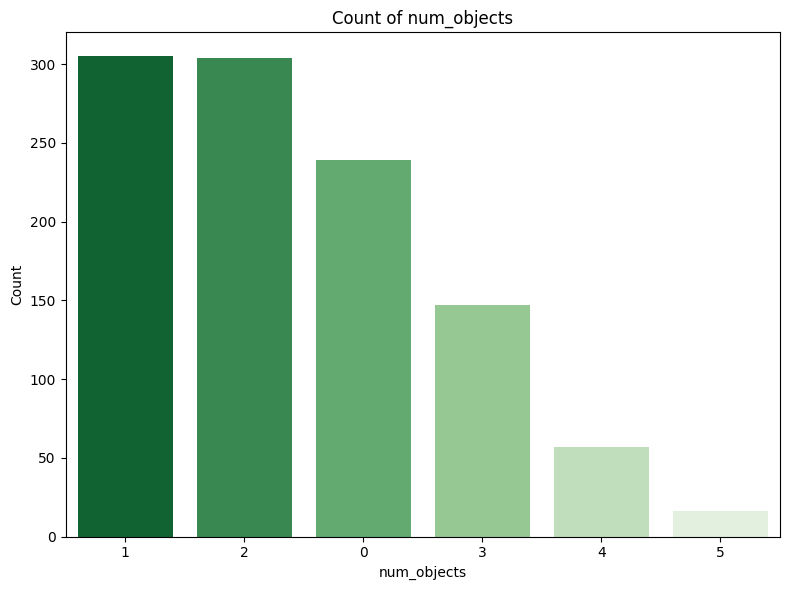

,num_objects,count,num_objects_ratio
0,1,305,28.56
1,2,304,28.46
2,0,239,22.38
3,3,147,13.76
4,4,57,5.34
5,5,16,1.50


In [27]:
count_plot(test_df, x_col='num_objects', palette='Greens_r')
num_objects = test_df['num_objects'].value_counts().reset_index()
num_objects.columns = ['num_objects', 'count']

num_objects['num_objects_ratio'] = (
    num_objects['count'] / len(test_df) * 100
).round(2)
num_objects

----

### BaseLine

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import torch
import yaml
import warnings
from ultralytics import YOLO
from tqdm import tqdm
from pathlib import Path
warnings.filterwarnings('ignore')
import sys

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# 환경에 따라 PROJECT_ROOT 설정
if IN_COLAB:
    PROJECT_ROOT = Path("/content/drive/MyDrive/likelion/PCB")
else:
    PROJECT_ROOT = Path.cwd().parent

# sys.path 추가 (import용)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 작업 디렉토리 변경 (파일 접근용) - 중요!
os.chdir(PROJECT_ROOT)

print(f"Environment: {'Colab' if IN_COLAB else 'Local'}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"Current working directory: {os.getcwd()}")

Environment: Colab
PROJECT_ROOT: /content/drive/MyDrive/likelion/PCB
Current working directory: /content/drive/MyDrive/likelion/PCB


In [2]:
from src.training.train import train_model
from src.models.model_factory import ModelFactory
from src.utils.config import load_config

config_path = f"{PROJECT_ROOT}/configs/train_config.yaml"
config = load_config(config_path)
config

{'model': {'type': 'yolo11', 'size': 's', 'pretrained': True},
 'data': {'data_yaml': 'dataset/raw/data.yaml', 'img_size': 600},
 'training': {'epochs': 30,
  'batch_size': 16,
  'device': 'cuda',
  'workers': 8,
  'patience': 10,
  'save_period': -1,
  'save_dir': 'outputs'},
 'augmentation': {'enabled': False,
  'pcb_optimized': False,
  'exclude_classes': []},
 'wandb': {'enabled': True,
  'project': 'PCB_Detection',
  'name': 'yolo_V11_s-base'},
 'experiment': {'name': 'yolo_V11_s-base', 'seed': 42}}

In [3]:
training_results = train_model(config_path=config_path)

2026-01-12 12:45:48 - INFO - Starting training...
INFO:PCB_Detection:Starting training...
2026-01-12 12:45:48 - INFO - Config: /content/drive/MyDrive/likelion/PCB/configs/train_config.yaml
INFO:PCB_Detection:Config: /content/drive/MyDrive/likelion/PCB/configs/train_config.yaml
2026-01-12 12:45:48 - INFO - Project root: /content/drive/MyDrive/likelion/PCB
INFO:PCB_Detection:Project root: /content/drive/MyDrive/likelion/PCB
2026-01-12 12:45:48 - INFO - Working directory: /content/drive/MyDrive/likelion/PCB
INFO:PCB_Detection:Working directory: /content/drive/MyDrive/likelion/PCB
2026-01-12 12:45:48 - INFO - Logs will be saved to: /content/drive/MyDrive/likelion/PCB/logs/yolo_V11_s-base
INFO:PCB_Detection:Logs will be saved to: /content/drive/MyDrive/likelion/PCB/logs/yolo_V11_s-base
2026-01-12 12:45:48 - INFO - Seed fixed to 42
INFO:PCB_Detection:Seed fixed to 42
2026-01-12 12:45:48 - INFO - Using device: cuda
INFO:PCB_Detection:Using device: cuda
2026-01-12 12:45:48 - INFO - Creating mo

2026-01-12 12:45:56 - INFO - W&B initialized for project='PCB_Detection', name='yolo_V11_s-base'
INFO:PCB_Detection:W&B initialized for project='PCB_Detection', name='yolo_V11_s-base'
2026-01-12 12:45:56 - INFO - Training parameters: {'data': '/content/drive/MyDrive/likelion/PCB/dataset/raw/data.yaml', 'epochs': 30, 'batch': 16, 'imgsz': 600, 'patience': 10, 'device': device(type='cuda'), 'workers': 8, 'save': True, 'save_period': -1, 'project': '/content/drive/MyDrive/likelion/PCB/outputs', 'name': 'yolo_V11_s-base', 'val': True, 'plots': True}
INFO:PCB_Detection:Training parameters: {'data': '/content/drive/MyDrive/likelion/PCB/dataset/raw/data.yaml', 'epochs': 30, 'batch': 16, 'imgsz': 600, 'patience': 10, 'device': device(type='cuda'), 'workers': 8, 'save': True, 'save_period': -1, 'project': '/content/drive/MyDrive/likelion/PCB/outputs', 'name': 'yolo_V11_s-base', 'val': True, 'plots': True}
2026-01-12 12:45:56 - INFO - Starting model training...
INFO:PCB_Detection:Starting model 

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/likelion/PCB/dataset/raw/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=600, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=weights/yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_V11_s-base, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, 

2026-01-12 13:59:26 - INFO - Training completed successfully
INFO:PCB_Detection:Training completed successfully
2026-01-12 13:59:26 - INFO - Best model saved at: /content/drive/MyDrive/likelion/PCB/outputs/yolo_V11_s-base/weights/best.pt
INFO:PCB_Detection:Best model saved at: /content/drive/MyDrive/likelion/PCB/outputs/yolo_V11_s-base/weights/best.pt
2026-01-12 13:59:26 - INFO - Best metrics logged to W&B: mAP50=0.9891, mAP50-95=0.5933
INFO:PCB_Detection:Best metrics logged to W&B: mAP50=0.9891, mAP50-95=0.5933


In [4]:
from src.evaluation.evaluate import Evaluator

weights_path = f"{PROJECT_ROOT}/outputs/yolo_V11_s-base/weights/best.pt"
data_yaml = f"{PROJECT_ROOT}/dataset/raw/data.yaml"

evaluator = Evaluator(weights_path=weights_path)
test_metrics = evaluator.evaluate(
    data_yaml=data_yaml,
    split='test',
    conf=0.001,  # 낮게 설정하여 모든 예측 포함
    iou=0.5,     # mAP 계산용 IoU threshold
    save_dir=f"{PROJECT_ROOT}/runs/evaluate",
    plots=True   # Confusion matrix, PR curve 등 생성
)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 0.1±0.0 MB/s, size: 104.5 KB)
val: Scanning /content/drive/MyDrive/likelion/PCB/dataset/raw/test/labels... 829 images, 239 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1068/1068 9.8it/s 1:499<0.0s
val: New cache created: /content/drive/MyDrive/likelion/PCB/dataset/raw/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 67/67 5.0it/s 13.5s0.2s
                   all       1068       1662       0.98      0.991       0.99      0.595
            mouse_bite        131        262      0.974      0.996      0.988      0.582
                  spur        138        279      0.989      0.978      0.989      0.592
          missing_hole        145        283      0.975          1      0.994      0.643
           

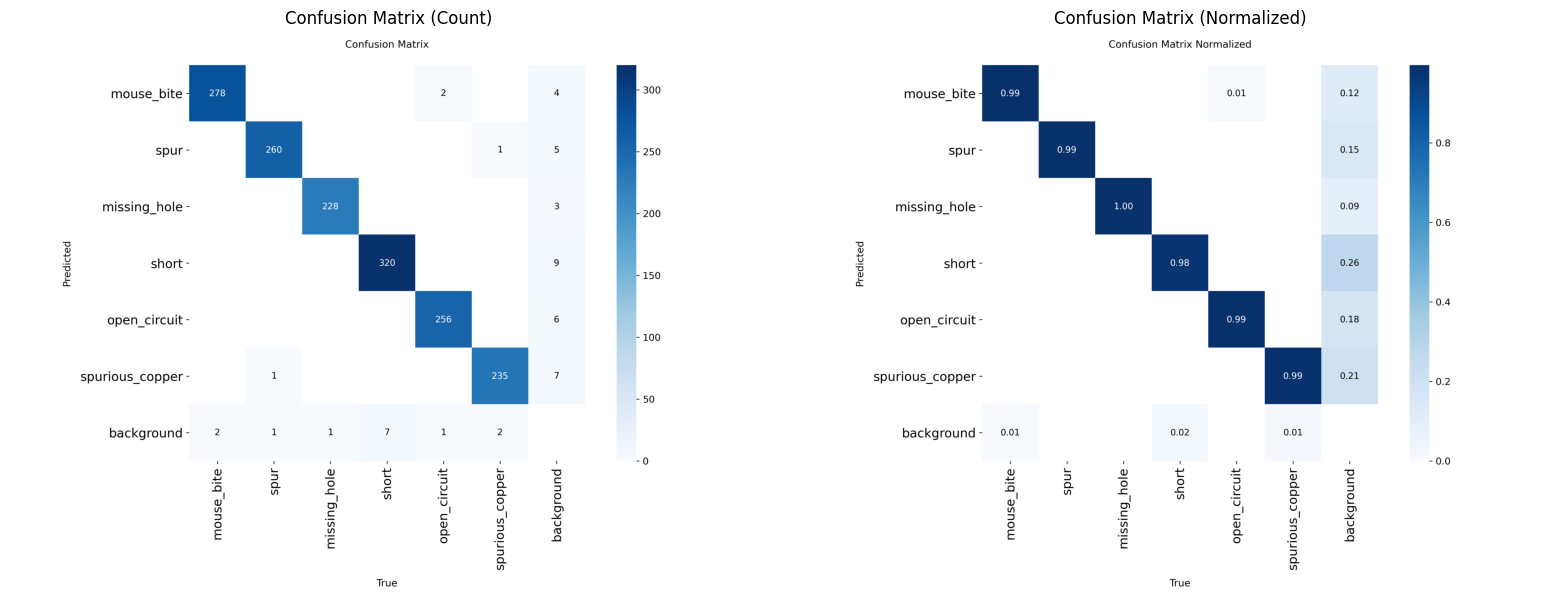

In [11]:
import cv2
import matplotlib.pyplot as plt

cm_path = f"{PROJECT_ROOT}/outputs/yolo_V11_s-base/confusion_matrix.png"
cm_norm_path = f"{PROJECT_ROOT}/outputs/yolo_V11_s-base/confusion_matrix_normalized.png"

cm_bgr = cv2.imread(cm_path)
cm_norm_bgr = cv2.imread(cm_norm_path)

cm_rgb = cv2.cvtColor(cm_bgr, cv2.COLOR_BGR2RGB)
cm_norm_rgb = cv2.cvtColor(cm_norm_bgr, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(cm_rgb)
axes[0].set_title("Confusion Matrix (Count)")
axes[0].axis('off')

axes[1].imshow(cm_norm_rgb)
axes[1].set_title("Confusion Matrix (Normalized)")
axes[1].axis('off')

plt.tight_layout()
plt.show()